In [1]:
from torch import nn


class SentenceClassifier(nn.Module):
    def __init__(
        self,
        n_vocab,
        hidden_dim,
        embedding_dim,
        n_layers,
        dropout=0.5,
        bidirectional=True,
        model_type="lstm"
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=embedding_dim,
            padding_idx=0
        )
        if model_type == "rnn":
            self.model = nn.RNN(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )
        elif model_type == "lstm":
            self.model = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )

        if bidirectional:
            self.classifier = nn.Linear(hidden_dim * 2, 1)
        else:
            self.classifier = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [2]:
import pandas as pd
from Korpora import Korpora


corpus = Korpora.load("nsmc")
corpus_df = pd.DataFrame(corpus.test)


    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : e9t@github
    Repository : https://github.com/e9t/nsmc
    References : www.lucypark.kr/docs/2015-pyconkr/#39

    Naver sentiment movie corpus v1.0
    This is a movie review dataset in the Korean language.
    Reviews were scraped from Naver Movies.

    The dataset construction is based on the method noted in
    [Large movie review dataset][^1] from Maas et al., 2011.

    [^1]: http://ai.stanford.edu/~amaas/data/sentiment/

    # License
    CC0 1.0 Universal (CC0 1.0) Public Domain Dedication
    Details in https://creativecommons.org/publicdomain/zero/1.0/

[Korpora] Corpus `nsmc` is already installed at C:\Users\mathn\Korpora\nsmc\ratings_train.txt
[Korpora] Corpus `nsmc` is already installed at C:\Users\mat

In [3]:
train = corpus_df.sample(frac=0.9, random_state=42)
test = corpus_df.drop(train.index)

In [4]:
from torchtext.vocab import build_vocab_from_iterator
from konlpy.tag import Okt

tokenizer = Okt()

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer.morphs(text)

vocab = build_vocab_from_iterator(yield_tokens(train), specials=["<unk>","<pad>"])

In [6]:
token_to_id = {token: idx for idx, token in enumerate(vocab.get_itos())}
id_to_token = {idx: token for idx, token in enumerate(vocab.get_itos())}

In [10]:
import numpy as np

# 정수 인코딩 및 패딩 
#  - sequences : 토큰화된 문장 데이터
#  - max_length : 최대 문장길이 즉, 1개 문장 구성 단어수
#  - pad : 패딩 처리 시 추가될 문자 값
#  - start : 패딩 시 처리 방향[기:R 오른쪽, 뒷부분 자르기/추가하기]
def pad_sequences(sequences, max_length, pad_value, start="R"):
    result = list()
    for sequence in sequences:
        sequence = sequence[:max_length] if start == "R" else sequence[-1*max_length:] # L이 입력되면 왼쪽을 채움(-1*max_length)
        pad_length = max_length - len(sequence)
        padded_sequence = sequence + [pad_value] * pad_length if start == "R" else  [pad_value] * pad_length + sequence # L이 입력되면 왼쪽을 채움(더하는 순서를 뒤집어주기)
        result.append(padded_sequence)
    return np.asarray(result)

unk_id = token_to_id["<unk>"]

train_ids = [
    [token_to_id.get(token, unk_id) for token in review] for review in train.text # 한 평가씩 읽어들여서, 한 토큰씩 아까 만든 딕셔너리를 참조하여 인덱스로 변환
]
test_ids = [
    [token_to_id.get(token, unk_id) for token in review] for review in test.text
]

In [15]:
train.text[0]

'굳 ㅋ'

[]

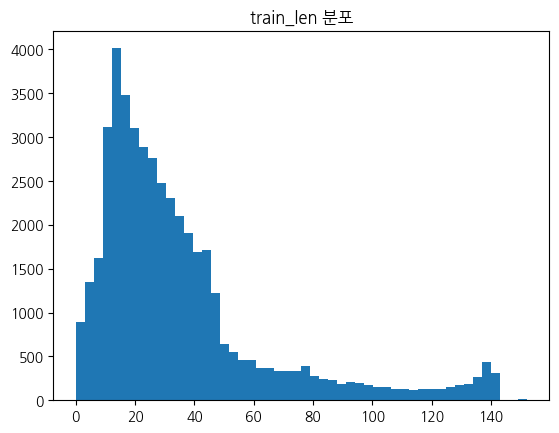

In [11]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

train_len=[]
for i in train_ids:
    train_len.append(len(i))

plt.hist(train_len, bins=50)
plt.title("train_len 분포")
plt.plot()

[]

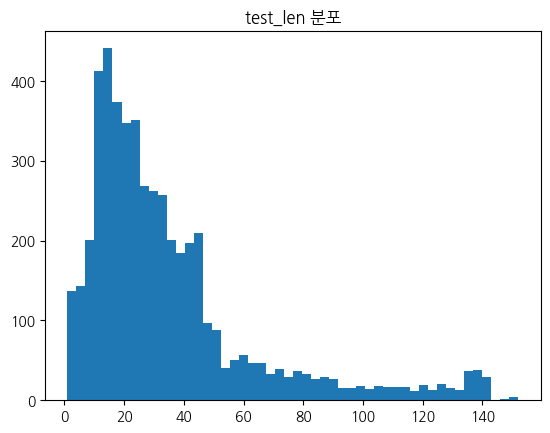

In [12]:

test_len=[]
for i in test_ids:
    test_len.append(len(i))

plt.hist(test_len, bins=50)
plt.title("test_len 분포")
plt.plot()

In [17]:
max_length = 64
pad_id = token_to_id["<pad>"]

train_ids = pad_sequences(train_ids, max_length, pad_id, start="R")
test_ids = pad_sequences(test_ids, max_length, pad_id, start="R")

print(train_ids[0])
print(test_ids[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 데이터셋, 데이터 로더 생성 
train_ids = torch.tensor(train_ids) # 인코딩된 데이터를 텐서로 변환
test_ids = torch.tensor(test_ids)

train_labels = torch.tensor(train.label.values, dtype=torch.float32) # 라벨값 데이터를 텐서로 변환 
test_labels = torch.tensor(test.label.values, dtype=torch.float32)

train_dataset = TensorDataset(train_ids, train_labels)
test_dataset = TensorDataset(test_ids, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [19]:
from torch import optim


n_vocab = len(token_to_id) # 총 단어 갯수 : 5002개 
hidden_dim = 64 
embedding_dim = 128
n_layers = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
classifier = SentenceClassifier( # 맨 처음에 만들었던, 클래스 인스턴스 생성 
    n_vocab=n_vocab, 
    hidden_dim=hidden_dim, 
    embedding_dim=embedding_dim, 
    n_layers=n_layers
).to(device)

criterion = nn.BCEWithLogitsLoss().to(device) # 이진분류에 걸맞는 BCEWithLogitsLoss()로 손실함수 설정
optimizer = optim.AdamW(classifier.parameters(), lr=0.001)  # 학습률이 빠른 AdamW로 옵티마이저 설정 

In [20]:
def train(model, datasets, criterion, optimizer, device, interval):
    model.train()
    losses = list()

    for step, (input_ids, labels) in enumerate(datasets): 
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % interval == 0:
            print(f"Train Loss {step} : {np.mean(losses)}")


def test(model, datasets, criterion, device):
    model.eval()
    losses = list()
    corrects = list()

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())
        yhat = torch.sigmoid(logits)>.5
        corrects.extend(
            torch.eq(yhat, labels).cpu().tolist()
        )

    print(f"Val Loss : {np.mean(losses)}, Val Accuracy : {np.mean(corrects)}")


epochs = 5
interval = 500

for epoch in range(epochs):
    train(classifier, train_loader, criterion, optimizer, device, interval)
    test(classifier, test_loader, criterion, device)

Train Loss 0 : 0.6987097263336182
Train Loss 500 : 0.6951797534367757
Train Loss 1000 : 0.6950324639216527
Train Loss 1500 : 0.6944230090849086
Train Loss 2000 : 0.6942638764674517
Train Loss 2500 : 0.6940819052446846
Val Loss : 0.6934374578463764, Val Accuracy : 0.4966
Train Loss 0 : 0.6979957222938538
Train Loss 500 : 0.69348566141909
Train Loss 1000 : 0.6934878008587139
Train Loss 1500 : 0.6934901798748319
Train Loss 2000 : 0.6935334835333684
Train Loss 2500 : 0.693535635920345
Val Loss : 0.6932723802118637, Val Accuracy : 0.4966
Train Loss 0 : 0.6969127058982849
Train Loss 500 : 0.6934790385221531
Train Loss 1000 : 0.6934276435163234
Train Loss 1500 : 0.6934421842770129
Train Loss 2000 : 0.6933778222056403
Train Loss 2500 : 0.6934090611792622
Val Loss : 0.6926784355419512, Val Accuracy : 0.5178
Train Loss 0 : 0.6948598027229309
Train Loss 500 : 0.6934016112557905
Train Loss 1000 : 0.6934689324457091
Train Loss 1500 : 0.693394656422772
Train Loss 2000 : 0.6934387501271471
Train Loss